<h2>Best viewed in <a href="https://nbviewer.jupyter.org/github/codykingham/noun_semantics_SBL18/blob/master/noun_semantics.ipynb?flush_cache=true?">Jupyter Notebook Viewer</a></h2>

# Noun Semantics in the Hebrew Bible

*This notebook will contain the descriptions and analysis for the presentation on noun semantics in the Hebrew Bible.*

In [1]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa

# stats & data-containers
import collections
import pandas as pd
import numpy as np
import scipy.stats as stats

# data visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# custom modules
from pyscripts.contextcount import ContextCounter, ContextTester
from pyscripts.contextparameters import deliver_params

# prep the data
name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'phono')] # data dirs
load_features = '''
heads typ phono lex_utf8 freq_lex pdp sp ls
prep_obj rela
''' 

# TF load statements
TF = Fabric(locations=hebrew_data)
api = TF.load(load_features)
B = Bhsa(api=api, hoist=globals(), silent=True, name=name) # Bhsa functions for search and visualizing text

This is Text-Fabric 6.4.4
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

120 features found and 0 ignored
  0.00s loading features ...
   |     0.16s B lex_utf8             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.19s B phono                from /Users/cody/github/etcbc/phono/tf/c
   |     0.67s B heads                from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.18s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.08s B freq_lex             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B pdp                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B sp                   from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.10s B ls                   from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.19s B prep_obj             from /Users/cody/gith

In [2]:
def reverse_hb(heb_text):
    '''
    Reverses order of left-to-right text 
    for good matplotlib formatting.
    '''
    return ''.join(reversed(heb_text))

def show_word_list(word_nodes, title=''):
    '''
    Displays Hebrew for a pipe-separated list of word nodes
    Good for seeing lexemes without taking up screen space.
    '''
    formatted = '&nbsp;&nbsp;|'.join(B.plain(node, asString=True) for node in word_nodes)
    display(HTML(formatted))

## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

In [3]:
raw_search = '''

lex language=Hebrew sp=subs

'''

raw_nouns = B.search(raw_search)

  0.02s 3706 results


Now we order the results on the basis of lexeme frequency.

In [4]:
raw_terms_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in raw_nouns), reverse=True)

Below we have a look at the top 50 terms from the selected set. Pay attention to the feature `ls`, i.e. "lexical set." This feature gives us some rudimentary semantic information about the nouns and their usual functions, and it suggests that some additional restrictions are necessary for the noun selection procedure. Note especially that several of these nouns are used in adjectival or prepositional roles (e.g.  כל ,אחד, אין, תחת).

In [5]:
raw_nnodes = [res[1] for res in raw_terms_ordered] # isolate the word nodes of the sample
B.prettySetup(features={'ls', 'freq_lex'}) # config B to display ls and freq_lex

# display lexeme data
for i, node in enumerate(raw_nnodes[:50]):
    B.prettyTuple((node,), seqNumber=i)



**Result** *0*





**Result** *1*





**Result** *2*





**Result** *3*





**Result** *4*





**Result** *5*





**Result** *6*





**Result** *7*





**Result** *8*





**Result** *9*





**Result** *10*





**Result** *11*





**Result** *12*





**Result** *13*





**Result** *14*





**Result** *15*





**Result** *16*





**Result** *17*





**Result** *18*





**Result** *19*





**Result** *20*





**Result** *21*





**Result** *22*





**Result** *23*





**Result** *24*





**Result** *25*





**Result** *26*





**Result** *27*





**Result** *28*





**Result** *29*





**Result** *30*





**Result** *31*





**Result** *32*





**Result** *33*





**Result** *34*





**Result** *35*





**Result** *36*





**Result** *37*





**Result** *38*





**Result** *39*





**Result** *40*





**Result** *41*





**Result** *42*





**Result** *43*





**Result** *44*





**Result** *45*





**Result** *46*





**Result** *47*





**Result** *48*





**Result** *49*



Based on the nouns that are present, we should make some key exclusions. Many substantives have more functional or adjectival roles. Undesirable categories include copulative nouns (`nmcp`, e.g. אין), cardinal numbers (`card`), potential prepositions (`ppre`, e.g. תחת). The `ls` category of potential adverb (`padv`) contains desirable nouns like יום, but also more functionally adverbial-nouns like עוד. Thus we can see that there is a range of adverbial tendencies found in this category. Due to the potentially interesting possibility of seeing these tendencies play out in the data, we can decide to keep these instances. 

To be sure, the very phenomenon of "functional" versus "nominal" is worthy of further, quantitative investigation. The `ls` feature is an experimental and incomplete feature in the ETCBC, and this is precisely the kind of shortcoming this present work seeks to address. Nouns and adverbs likely sit along a sliding scale of adverbial tendencies, with adverbs nearly always functioning in such a role, and nouns exhibiting various statistical tendencies. But due to the scope of this investigation, we limit ourselves to mainly nominal words with a small inclusion of some adverbial-like substantives.

We can eliminate more functional nouns by restricting the possible lexical set (`ls`) values. Below we apply those restrictions to the search template. In the case of certain quantifiers such as כל there is an `ls` feature of distributive noun (`nmdi`), yet this feature is likewise applied to nouns such as אח ("brother"). So it is undesirable to exclude all of these cases. Thus we depend, instead, on an additional filter list that excludes quantifiers.

A few terms such as דרך and עבר are eliminated because the ETCBC labels it as a potential preposition. This is a speculative classification. So we define a seperate parameter in the template that saves this instance.

In [6]:
exclude = '|'.join(('KL/', 'M<V/', 'JTR/', 'M<FR/', 'XYJ/')) # exclude quantifiers
include = '|'.join(('padv', 'nmdi'))  # ok ls features
keep = '|'.join(('DRK/', '<BR/'))

'''
Below is a TF search query for three cases:
One is a lexeme with included ls features.
The second is a lexeme with a null ls feature.
The third is lexemes we want to prevent from being excluded.
For all cases we exclude excluded lexemes.
'''

select_noun_search = f'''

lex language=Hebrew
/with/
sp=subs ls={include} lex#{exclude}
/or/
sp=subs ls# lex#{exclude}
/or/
sp=subs lex={keep}
/-/

'''

select_nouns = B.search(select_noun_search)
noun_dat_ordered = sorted(((F.freq_lex.v(res[0]), res[0]) for res in select_nouns), reverse=True)
nnodes_ordered = list(noun_dat[1] for noun_dat in noun_dat_ordered)
filtered_lexs = list(node for node in raw_nnodes if node not in nnodes_ordered)

print(f'\t{len(raw_nouns) - len(select_nouns)} results filtered out of raw noun list...')
print('\tfiltered lexemes shown below:')
show_word_list(filtered_lexs)

  0.02s 3658 results
	48 results filtered out of raw noun list...
	filtered lexemes shown below:


### Plot the Nouns in Order of Frequency

Now that we have obtained a filtered noun-set, we must decide a cut-off point at which to limit the present analysis. Below we plot the attested nouns and their respective frequencies.

[]

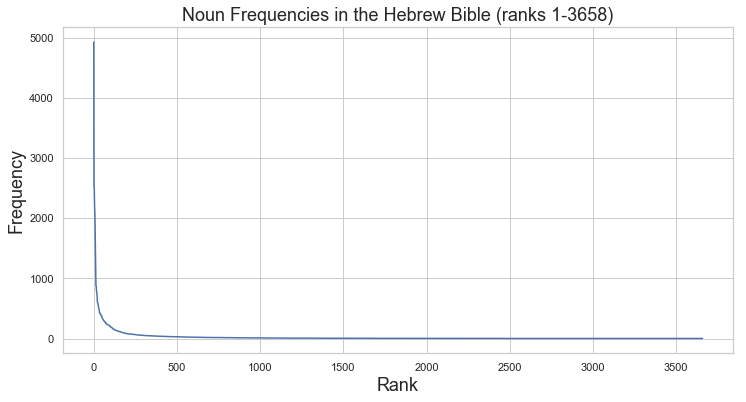

In [7]:
# plot data
y_freqs = [lex_data[0] for lex_data in noun_dat_ordered]
x_rank = [i+1 for i in range(0, len(y_freqs))]
title = 'Noun Frequencies in the Hebrew Bible'
xlabel = 'Rank'
ylabel = 'Frequency'

# first plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank, y_freqs)
plt.title(title + f' (ranks 1-{len(x_rank)})', size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

We zoom in closer to view ranks 1-1000...

*Consider using a subplot here with 4 different zooms*

[]

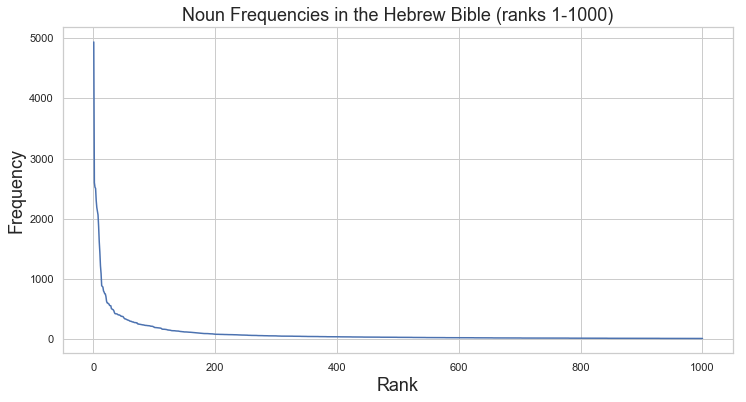

In [8]:
# second plot
plt.figure(figsize=(12, 6))
plt.plot(x_rank[:1000], y_freqs[:1000])
plt.title(title + f' (ranks 1-1000)', size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

This curve is typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve sharply "elbows" at around rank 15. Between ranks 50-100 there is still an appreciable drop-off. The curve starts to significantly flatten after 200. We thus decide an arbitrary cut-off point at rank 200, based on the fact that the curve does not show any significant leveling after this point.

In [9]:
target_nouns = nnodes_ordered[:200]
tnoun_instances = set(word for lex in target_nouns for word in L.d(lex, 'word'))

show_word_list(target_nouns) # temporary comment out while bug is fixed
print(f'\n{len(tnoun_instances)} nouns ready for searches')


73991 nouns ready for searches


## Strategy for Context Selection

See [pyscripts/contextparameters.py](pyscripts/contextparameters.py) for the full delineation of these patterns and to see how they've been selected and tokenized. **This is a work in progress.**

* phrase-type relations
    * PP and their objcs

* subphrase relations
    * parallel (`par`) — syndetic connections
    * regens/rectum (`rec`) — nomen regens/rectum relations
    * adjunct (`adj`)
    * attribute (`atr`)
    

* phrase_atom relations
    * apposition (`appo`) — re-identification relations
    * parallel and link, what is the difference here?
    * specification, what is it?
    
    
* clause-constituent relations
    * "is a" relations with היה (subjects || predicate complements)
    * all other predicate / function roles — FRAMES

In [10]:
contexts = deliver_params(tnoun_instances, tf=api)

In [11]:
print('The following contextual relations will be queried (. without lex = target noun; -> = relation):')
for i, param in enumerate(contexts):
    name = param['name']
    print(f'{i+1}. {name}')

The following contextual relations will be queried (. without lex = target noun; -> = relation):
1. funct.-> st.verb.lex
2. funct.prep-> st.verb.lex
3. PreC.lex-> Subj.
4. PreC.prep.lex-> Subj.
5. PreC.-> Subj.lex
6. PreC.-> Subj.prep.lex
7. par.lex-> .
8. par.-> lex
9. atr.lex -> .
10. rec.lex -> .
11. rec.-> lex
12. Para.lex-> .
13. Para.-> lex
14. Appo.lex-> .
15. Appo.-> lex


In [12]:
counts = ContextCounter(contexts, tf=api, report=True)

running query on template [ funct.-> st.verb.lex ]...
	19276 results found.
running query on template [ funct.prep-> st.verb.lex ]...
	14935 results found.
running query on template [ PreC.lex-> Subj. ]...
	2559 results found.
running query on template [ PreC.prep.lex-> Subj. ]...
	1125 results found.
running query on template [ PreC.-> Subj.lex ]...
	964 results found.
running query on template [ PreC.-> Subj.prep.lex ]...
	4 results found.
running query on template [ par.lex-> . ]...
	2121 results found.
running query on template [ par.-> lex ]...
	2037 results found.
running query on template [ atr.lex -> . ]...
	1507 results found.
running query on template [ rec.lex -> . ]...
	1435 results found.
running query on template [ rec.-> lex ]...
	1692 results found.
running query on template [ Para.lex-> . ]...
	669 results found.
running query on template [ Para.-> lex ]...
	596 results found.
running query on template [ Appo.lex-> . ]...
	1410 results found.
running query on template 

Below we look at the number of dimensions in the data:

In [13]:
counts.data.shape

(12202, 199)

And a sample of the data is below:

In [14]:
counts.data.head()

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.<LH[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.<TR[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.BW>[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.CLK[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Adju.-> hif.JBL[,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that one of the original target lexemes have been omitted because they fell below the 10 observation threshold. Let's see which ones they are.

In [15]:
set(F.lex.v(w) for w in tnoun_instances) - set(F.lex.v(counts.target2node[token]) for token in counts.data.columns)

{'N>M/'}

The noun נאֻם is omitted due to lack of relevant data. We thus continue with **199 target nouns.**

Next we look at a few example counts:

In [16]:
counts.data['>LHJM/'][counts.data['>LHJM/'] > 0].sort_values(ascending=False)

Appo.-> JHWH/           730.0
atr.>XR=/-> .            61.0
Subj.-> qal.>MR[         50.0
Subj.-> qal.NTN[         32.0
Objc.-> qal.<BD[         29.0
Subj.-> qal.<FH[         23.0
Appo.>LHJM/-> .          18.0
Appo.-> >LHJM/           18.0
Cmpl.>XR/-> qal.HLK[     15.0
Subj.-> qal.R>H[         13.0
Objc.-> qal.JR>[         13.0
Subj.-> piel.DBR[        12.0
PreC.B-> Subj.           11.0
PreC.-> Subj.JHWH/       11.0
Subj.-> qal.CM<[         10.0
Subj.-> piel.BRK[         9.0
Objc.-> qal.<FH[          9.0
Subj.-> qal.BW>[          8.0
Appo.-> PNH/              8.0
Cmpl.>L-> qal.>MR[        8.0
Subj.-> hif.NYL[          8.0
Subj.-> piel.YWH[         7.0
Objc.-> qal.DRC[          7.0
Cmpl.L-> piel.QVR[        7.0
Cmpl.B-> qal.C>L[         7.0
Subj.-> qal.CLX[          7.0
Objc.-> piel.BRK[         7.0
Subj.-> qal.BR>[          6.0
Cmpl.L-> qal.ZBX[         6.0
Objc.-> qal.R>H[          6.0
                        ...  
Subj.-> hif.NKH[          1.0
Subj.-> hif.NWX[          1.0
Subj.-> hi

This gives a good idea of the content of the co-occurrence counts.

## Count Adjustments

We will apply two primary adjustments:

1. We drop co-occurrences that are unique to a noun. The dropped observations will thus be considered outliers. While these items are useful for describing the uniqueness of a given lexeme, they are unhelpful for drawing comparisons between our sets. 
2. We convert the counts into a measure of statistical significance. For this we use Fisher's exact test, which is ideal for datasets that have counts that are less than 5. Our matrix is likely to have many such counts. 

### Remove Unique Co-occurrences

We select colexemes/basis counts that only occur with one target noun. This is done by subtracting the row total from each item in the row. Any 0 value in a row means that that row has a unique colexeme that only occurs with one target noun (we will call that a `hapax_colex` here). We will remove these rows further down.

In [17]:
colex_counts = counts.data.sum(1)
remaining_counts = counts.data.sub(colex_counts, axis=0) # subtract colex_counts
hapax_colex = remaining_counts[(remaining_counts == 0).any(1)] # select rows that have a 0 value anywhere

Below is an example just to make sure we've selected the right indices. The value has been manually chosen from `hapax_colex`.

In [18]:
counts.data.loc['rec.XTN/-> .'].sort_values(ascending=False).head()

QWL/     8.0
RB=/     0.0
JJN/     0.0
>B/      0.0
ML>K/    0.0
Name: rec.XTN/-> ., dtype: float64

Below we see that `8191` colexemes only occur with one given noun. This is a significant amount. We drop these rows in the next cell and name our dataset `data`.

In [19]:
hapax_colex.shape

(8191, 199)

In [20]:
data = counts.data.drop(labels=hapax_colex.index, axis=0)

print(f'New data dimensions: {data.shape}')
print(f'New total observations: {data.sum().sum()}')
print(f'Observations removed: {counts.data.sum().sum() - data.sum().sum()}')

New data dimensions: (4011, 199)
New total observations: 42097.0
Observations removed: 11870.0


Random example to make sure there are no unique colexemes in the new dataset:

In [21]:
data.loc['Adju.-> hif.BW>['].sort_values(ascending=False).head(5)

KLJ/     1.0
ZHB/     1.0
>JL=/    1.0
KSP/     1.0
RB=/     0.0
Name: Adju.-> hif.BW>[, dtype: float64

#### Check for Orphaned Target Nouns

There is one additional test. We want to see if any target nouns in the dataset have been orphaned by these changes: i.e. do any target nouns have zero co-occurrence data after the changes?

In [22]:
data.loc[:, (data == 0).all(0)].shape

(4011, 0)

There are no columns (i.e. target nouns) with 0 observations, and hence no orphans. Thus we move ahead with the count adjustments.

### Apply Fisher's Exact Test

Now we apply the Fisher's exact test to the data set. This involves supplying values to a 2x2 contingency table that is fed to `scipy.stats.fisher_exact`

In [69]:
# data for contingency tables
target_obs = data.apply(lambda col: col.sum(), axis=0, result_type='broadcast') # total target lexeme observations
colex_obs = data.apply(lambda col: col.sum(), axis=1, result_type='broadcast') # total colexeme/basis observations
total_obs = data.sum().sum() # total observations

# parts of contingency formula; a=data
b_matrix = target_obs.sub(data)
c_matrix = colex_obs.sub(data)
d_matrix = pd.DataFrame.copy(data, deep=True)
d_matrix[:] = total_obs
d_matrix = d_matrix.sub(data+b+c)

fisher_transformed = collections.defaultdict(lambda: collections.defaultdict(float))

i = 0
for lex in data.columns:
    for colex in data.index:
        a = data[lex][colex]
        b = b_matrix[lex][colex]
        c = c_matrix[lex][colex]
        d = d_matrix[lex][colex]
        contingency = np.matrix([[a, b], [c, d]])
        oddsratio, pvalue = stats.fisher_exact(contingency)
        fisher_transformed[lex][colex] = pvalue
        i += 1
        if i % 100000 == 0: # update every 100,000 iterations; should be 798,189 total (4011x199)
            print(f'finished iteration {i}...')
print('done!')

#fisherdata = pd.DataFrame(fisher_transformed)

finished iteration 100000...
finished iteration 200000...
finished iteration 300000...
finished iteration 400000...
finished iteration 500000...
finished iteration 600000...
finished iteration 700000...
done!


In [71]:
fisherdata = pd.DataFrame(fisher_transformed)

In [72]:
fisherdata

,>LHJM/,>RY/,>WR/,JWM/,LJLH/,CMJM/,MJM/,JM/,<Y/,NPC/,...,MMLKH/,D<T/,<WLM/,TWK/,FMXH/,HJKL/,<T/,RXB=/,>RK=/,RB=/
Adju.-> hif.BW>[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> hif.NKH[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> nif.>SP[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> nif.CMM[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> piel.DBR[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> qal.<BD[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,0.022142,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> qal.<FH[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> qal.HLK[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> qal.JCB[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
Adju.-> qal.JLD[,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.0,1.0,1.000000,0.030615,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000


<hr>
<br>
<br>
<br>